In [1]:
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

import deepchem.feat.graph_features
import deepchem as dc
from deepchem import splits

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import classification_report
from sklearn.utils import resample
from math import sqrt

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
from sklearn.metrics import r2_score
import kerastuner as kt
import tensorflow.compat.v1 as tf

from collections import Counter 
import pickle
import pandas as pd
import collections
import seaborn as sns
sns.set_theme(style='ticks', palette='bright', font='sans-serif', font_scale=1.2)

from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
tf.keras.backend.set_floatx('float64')

In [8]:
#read all of the relevant datasets and processed input datasets
Dataset1_Smiles_P = pd.read_csv("dataset1_imputed_all.csv")
Dataset1_grouped = Dataset1_Smiles_P.groupby('Smiles').mean().reset_index()
X_fingerprints = pd.read_csv('dataset1X_fingerprints.csv')
X_fingerprints = X_fingerprints.drop(X_fingerprints.columns[0], axis=1)
X_descriptors = pd.read_csv('dataset1X_descriptors.csv')
X_descriptors = X_descriptors.drop(X_descriptors.columns[0], axis=1)
dataset2X_fingerprints= pd.read_csv('dataset2X_fingerprints.csv')
dataset2X_fingerprints = dataset2X_fingerprints.drop(dataset2X_fingerprints.columns[0], axis=1)
dataset3X_fingerprints= pd.read_csv('dataset3X_fingerprints.csv')
dataset3X_fingerprints = dataset3X_fingerprints.drop(dataset3X_fingerprints.columns[0], axis=1)
Dataset3_Smiles = pd.read_csv("dataset3.csv")
Dataset2_Smiles = pd.read_csv("dataset2.csv")

In [4]:
#convert to get the fingerprint for substructure identification during interpretable feature selection
molecules = Dataset1_grouped.Smiles.apply(Chem.MolFromSmiles)
fp = molecules.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_n = fp.apply(lambda m: m.GetNonzeroElements())

# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_n:
    for j in i.keys():
        HashCode.append(j)
        
unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

#construct dataset-1 input
MY_finger = []
for polymer in fp_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)
    
MY_finger_dataset_1 = pd.DataFrame(MY_finger)  

### Useful Functions

In [5]:
#user defined mean squared errors that ignores NaN values, used as the loss function when training on non-imputed data with missing entries
def nanmean_squared_error(y_true, Y_pred):
    Y_pred = ops.convert_to_tensor_v2(Y_pred)
    y_true = math_ops.cast(y_true, Y_pred.dtype)
    residuals = (y_true - Y_pred)
    residuals_no_nan = tf.where(tf.math.is_nan(residuals), tf.zeros_like(residuals), residuals)
    sum_residuals = tf.reduce_sum(math_ops.squared_difference(residuals_no_nan , 0),-1) / tf.reduce_sum(tf.cast(~tf.math.is_nan(y_true), tf.float64),-1)
    return sum_residuals

In [6]:
# evaluate a single DNN for regression 
def evaluate_model(trainX, trainy, testX, testy):
    model = keras.models.Sequential()
    model.add(Dense(units = 64, input_dim = X.shape[1],activation='relu'))
    model.add(Dense(units = 64, activation='relu'))
    model.add(Dense(units = 32, activation='relu'))
    model.add(Dense(units = 16, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units = 6))

    # model.summary()
    #model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.compile(loss = nanmean_squared_error, optimizer = 'adam')
    history = model.fit((trainX), trainy, epochs = 50, batch_size = 64, validation_data = ((testX), testy), verbose=0)
    
    # evaluate the model
    predy = model.predict((testX))
    test_r2 = np.zeros(6)
    for i in range(6):
        flag1 = ~np.isnan(testy[:,i])
        test_r2[i] = r2_score(testy[:,i][flag1], predy[:,i][flag1], multioutput='raw_values')
    return model, test_r2

# make an ensemble prediction
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    # mean of ensemble members
    predictions = np.mean(yhats, axis=0)
    variances = np.var(yhats, axis=0)
    #print(summed)
    return predictions, variances

# evaluate a specific number of members in an ensemble for the regression score (R2) and the variance of predictions
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat, variances = ensemble_predictions(subset, testX)
    avg_var = np.mean(variances, axis =0)
    
    # calculate R2
    test_r2 = np.zeros(6)
    for i in range(6):
        flag1 = ~np.isnan(testy[:,i])
        test_r2[i] = r2_score(testy[:,i][flag1], yhat[:,i][flag1], multioutput='raw_values')
    return test_r2, avg_var

# Supverised Multitask Regression Models

### Select the correct input and output data

In [12]:
#X = X_descriptors.copy()
#Xscaler = StandardScaler()
#X = Xscaler.fit_transform(X)
X = X_fingerprints.copy()

#inputs to be used for high throughput screening
X_pred = dataset2X_fingerprints

#Y = Dataset1_grouped.iloc[:,-18:-12] #No imputation
Y = Dataset1_grouped.iloc[:,-12:-6] #Bayesian imputation
#Y = Dataset1_grouped.iloc[:,-6:] #Etree imputation
Y = np.array(Y)
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Select the desired ML model (only run one cell in this section)

In [242]:
#for lasso regression model, run this
# hyperparameters
alpha = 0.1
cv = 10

# build model
model = Lasso(alpha=alpha).fit(X_train, Y_train)
# get prediction
Y_pred_train = cross_val_predict(model, X_train, Y_train, cv=cv) # cross-validation
Y_pred_test = cross_val_predict(model, X_test, Y_test, cv=cv)
# calculate the metrics
final_R2 = r2_score(Y_train,Y_pred_train)
final_MAE = mean_absolute_error(Y_train,Y_pred_train)
# metrics of the score
scores = cross_validate(model, X_train, Y_train, cv=cv,
scoring=('r2', 'neg_mean_absolute_error'),return_train_score=True)
# save the score
score_df = pd.DataFrame.from_dict(scores)
# save the model
#pickle.dump(model, open("./LASSO.model", 'wb'))
wts = model.coef_
#np.savetxt("./weights.txt", wts, fmt="%5.3f")

Y_pred = model.predict(X_pred)
Y_pred = scaler.inverse_transform(Y_pred)

In [13]:
#for the random forest, run this
model = RandomForestRegressor(n_estimators=200, max_depth = 10, bootstrap = True, max_features = 'sqrt')

#for gaussian process regression, run this instead
#kernel = RBF() + WhiteKernel()
#model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=0)

#fit the model
history = model.fit(X_train, Y_train)

#use the model to make predictions
Y_pred_train = model.predict((X_train))
Y_pred_train = scaler.inverse_transform(Y_pred_train)
Y_pred_test = model.predict((X_test))
Y_pred_test = scaler.inverse_transform(Y_pred_test)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

#screen the hypothetical polymers
Y_pred = model.predict(X_pred)
Y_pred = scaler.inverse_transform(Y_pred)

In [14]:
#for the ensemble of DNNs, run this (also quantifies uncertainty)
n_splits = 16
scores, members = list(), list()
for _ in range(n_splits):
    # select indexes
    ix = [i for i in range(len(X))]
    train_ix = resample(ix, replace=True, n_samples=round(X.shape[0]*0.8)) #254 is about 90% of the non-holdout set
    test_ix = [x for x in ix if x not in train_ix]
    # select data
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model

    model, test_r2 = evaluate_model(trainX, trainy, testX, testy)
    print(test_r2)
    scores.append(test_r2)
    members.append(model)
# summarize expected performance
print('Mean R2: ' + str(np.mean(scores, axis = 0)))
print('Estimated Std of R2: ' + str(np.std(scores, axis = 0)))

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    ensemble_score, ensemble_variance = evaluate_n_members(members, i, newX, newy)
    #single_score = r2_score(newy, members[i-1].predict(newX), multioutput='raw_values')
    print(str(i) + ' Single R2s: ' + str(single_score))
    print(str(i) + ' Ensemble R2s: ' + str(ensemble_score))
    print(str(i) + ' Ensemble pred var: ' + str(ensemble_variance))
    print(' ')
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

#use the models to make predictions
Y_pred_train, var = ensemble_predictions(members, X)
Y_pred_train = scaler.inverse_transform(Y_pred_train)
Y_pred_test, var = ensemble_predictions(members, newX)
Y_pred_test = scaler.inverse_transform(Y_pred_test)
Y_train = scaler.inverse_transform(y)
Y_test = scaler.inverse_transform(newy)

Y_pred, Y_var = ensemble_predictions(members, X_pred)
Y_pred = scaler.inverse_transform(Y_pred)

KeyError: "None of [Int64Index([208, 140, 140, 160, 222, 188,  40, 137, 202, 190,\n            ...\n             84,   3, 127, 108, 209, 190,  21,  13,  33, 321],\n           dtype='int64', length=282)] are in the [columns]"

In [15]:
#for the graph convolution model, run this instead
X = Dataset1_grouped['Smiles']

#preprocess the smiles strings for graph convolution
featurizer = dc.feat.ConvMolFeaturizer()
f = featurizer.featurize(X)

#Y = Dataset1_grouped.iloc[:,-18:-12] #No imputation
Y = Dataset1_grouped.iloc[:,-12:-6] #Bayesian imputation
#Y = Dataset1_group.iloc[:,-6:] #Etree imputation
Y = Y.to_numpy()
scaler = StandardScaler()
Y = scaler.fit_transform(Y)
dataset = dc.data.NumpyDataset(X=f, y=Y)

#GraphConvModel
model = dc.models.GraphConvModel(6, batch_size=64, mode='regression')
model.fit(train_set, nb_epoch=100)

#now get the predictions
Y_pred_train = model.predict(train_set)
Y_train = train_set.y

Y_pred_train = scaler.inverse_transform(Y_pred_train)
Y_pred_test = model.predict(test_set)
Y_test = test_set.y

Y_pred_test = scaler.inverse_transform(Y_pred_test)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

#screen the hypothetical polymers
dataset2X_Smiles = Dataset2_Smiles['Smiles']
#preprocess the smiles strings for graph convolution
featurizer = dc.feat.ConvMolFeaturizer()
dataset2X_features = featurizer.featurize(dataset2X_Smiles)
dataset2X_Gconv = dc.data.NumpyDataset(X=dataset2X_features)

Y_pred = model.predict(dataset2X_Gconv)
Y_pred = scaler.inverse_transform(Y_pred)

NameError: name 'train_set' is not defined

### Plot the performance and predictions

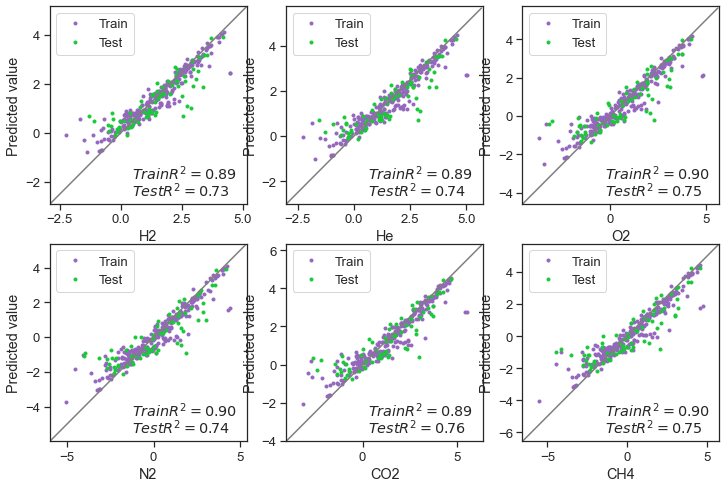

In [16]:
#plot the performance of the model for six gases
Columns = ['H2','He','O2','N2','CO2','CH4']

fig = plt.figure(figsize=(12,8))
for i in range(6):
    ax=plt.subplot(2, 3, i + 1)
    index = i #adjust so that we look at the last 4 gases
    plt.plot(Y_train[:,index], Y_pred_train[:,index], '.', color='tab:purple')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
    plt.plot(Y_test[:,index], Y_pred_test[:,index], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
    plt.legend(['Train', 'Test'], loc = 'best')
    plt.xlabel(Columns[i]) 
    plt.ylabel("Predicted value")
    x0, x1 = min(Y_train[:,index]), max(Y_train[:,index])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), '-', color='tab:gray')
    plt.text(x_end - 0.7*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index], Y_pred_train[:,index])))
    plt.text(x_end - 0.7*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index], Y_pred_test[:,index])))

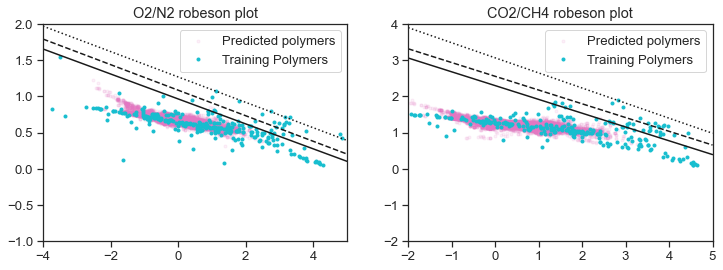

In [17]:
#plot the predicted permeability values for dataset2 on the robeson plot
fig = plt.figure(figsize=(12,4))

#O2/N2 Robeson Plot
plt.subplot(1,2,1)
permeability = Y_pred[:,-4]
selectivity = Y_pred[:,-4] - Y_pred[:,-3]
plt.plot(permeability, selectivity, '.',  color='tab:pink', alpha = 0.1)

permeability = Y_train[:,-4]
selectivity = Y_train[:,-4] - Y_train[:,-3]
plt.plot(permeability, selectivity, '.', color='tab:cyan')
xmin = -4
xmax = 5
plt.xlim([xmin, xmax])
plt.ylim([-1, 2])
plt.plot([xmin, xmax], [np.log10(9.2008)-0.1724*xmin, np.log10(9.2008)-0.1724*xmax], '-k') #1991 upper bound
plt.plot([xmin, xmax], [np.log10(12.148)-0.1765*xmin, np.log10(12.148)-0.1765*xmax], '--k') #2008 upper bound
plt.plot([xmin, xmax], [np.log10(18.50)-0.1754*xmin, np.log10(18.50)-0.1754*xmax], ':k') #2015 upper bound
plt.title("O2/N2 robeson plot")
plt.legend(['Predicted polymers', 'Training Polymers'])

#CO2/CH4 Robeson Plot
plt.subplot(1,2,2)
permeability = Y_pred[:,-2]
selectivity = Y_pred[:,-2] - Y_pred[:,-1]
plt.plot(permeability, selectivity, '.', color='tab:pink', alpha=0.1)
xmin = -2
xmax =5
plt.xlim([xmin, xmax])
plt.ylim([-2, 4])
permeability = Y_train[:,-2]
selectivity = Y_train[:,-2] - Y_train[:,-1]
plt.plot(permeability, selectivity, '.', color='tab:cyan')

plt.plot([xmin, xmax], [np.log10(197.81)-0.3807*xmin, np.log10(197.81)-0.3807*xmax], '-k') #1991 upper bound
plt.plot([xmin, xmax], [np.log10(357.33)-0.3794*xmin, np.log10(357.33)-0.3794*xmax], '--k') #2008 upper bound
plt.plot([xmin, xmax], [np.log10(1155.60)-0.4165*xmin, np.log10(1155.60)-0.4165*xmax], ':k') #2019 upper bound
plt.title('CO2/CH4 robeson plot')
plt.legend(['Predicted polymers', 'Training Polymers'])

# Classification

In [1230]:
Y = Dataset1_grouped.iloc[:,-18:-12] #No imputation
#Y = Dataset1_grouped.iloc[:,-12:-6] #Bayesian imputation
#Y = Dataset1_grouped.iloc[:,-6:] #Etree imputation
Y = np.array(Y)
highperf_ON_classification = 1*(Y[:,-4] - Y[:,-3] > np.log10(12.148) - 0.1765*Y[:,-4])
highperf_CC_classification = 1*(Y[:,-2] - Y[:,-1] > np.log10(357.33)-0.3794*Y[:,-2])
highperf_ON_classification

X_train, X_test, Y_train, Y_test = train_test_split(X, highperf_ON_classification, test_size=0.20, random_state=43)

### Select the desired ML model (only run one cell in this section)

In [1231]:
#random forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth = 10, bootstrap = True, max_features = 'sqrt')

#Gaussian process classifier
kernel = RBF() + WhiteKernel()
model = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10, random_state=0).fit(X_train, Y_train)
  
history = model.fit(X_train, Y_train)

In [ ]:
#DNN classifier
model = keras.models.Sequential()
#model.add(Dense(units = 64, input_dim = X.shape[1],activation='relu'))
#model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 16, activation='relu'))
model.add(Dense(units = 8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation='sigmoid'))
 
# model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model.fit((X_train), Y_train, epochs = 100, batch_size = 64, validation_data = ((X_test), Y_test), verbose=2)

### Provide a classification report

In [1232]:
Y_pred_train = model.predict((X_train))
Y_pred_test = model.predict((X_test))
print(classification_report(Y_train, Y_pred_train))
print(classification_report(Y_test, Y_pred_test))
Y_pred = (model.predict(dataset2X_fingerprints)>0.5)*1

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       250
           1       1.00      0.86      0.92        14

    accuracy                           0.99       264
   macro avg       1.00      0.93      0.96       264
weighted avg       0.99      0.99      0.99       264

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        81
           1       0.60      0.38      0.46         8

    accuracy                           0.92        89
   macro avg       0.77      0.68      0.71        89
weighted avg       0.91      0.92      0.91        89

